In [1]:
#default_exp basics

# Linear models & causaling
> My attempt to learn about using Bayesian causal reasoning with the dowhy package by  generating observational data using a linear model, estimating the causal effect, trying to refute it and comparing it to other tools.

In [2]:
#hide
%load_ext autoreload
%autoreload 2
%matplotlib inline

dowhy references:
* Documentation: [here](https://microsoft.github.io/dowhy/)
* GitHub: [here](https://github.com/microsoft/dowhy)

Random references:
* average treatment effect (ATE): [wiki](https://en.wikipedia.org/wiki/Average_treatment_effect)
* average treatment effect among treated (ATT): [nih article](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4098642/)
* average treatment effect fro the control (ATC)
* calculating ATE and ATT: [article](https://www.tandfonline.com/doi/full/10.1080/00273171.2011.568786)
* calculating WATE, ATT and ATC: [article](https://arxiv.org/pdf/1804.05079.pdf)
* backdoor path: [youtube video](https://www.youtube.com/watch?v=F8vcki-uWJc)
* propensity score (matching):
    * [wiki](https://en.wikipedia.org/wiki/Propensity_score_matching)
    * a not very clear medical [nih article](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6760465/)
* the *do*-operator / interventions and counterfactuals: [article](https://www.ucl.ac.uk/lagnado-lab/publications/lagnado/intervention%20hagmayer%20et%20al.pdf)
* potential oucomes: [Rubin et al. 2005](http://www.stat.unipg.it/stanghellini/rubinjasa2005.pdf)
* blogs:
    * degeneratestate: [Pt I - potential outcomes](http://www.degeneratestate.org/posts/2018/Mar/24/causal-inference-with-python-part-1-potential-outcomes/) (contains definitions of ATE, ATT and ATC, among other things), [Pt II - backdoor criterion](http://www.degeneratestate.org/posts/2018/Jul/10/causal-inference-with-python-part-2-causal-graphical-models/), [Pt III - frontdoor criterion](http://www.degeneratestate.org/posts/2018/Sep/03/causal-inference-with-python-part-3-frontdoor-adjustment/)
    * michaelnielsen: [If correlation doesn't imply causation, then what does?](http://www.michaelnielsen.org/ddi/if-correlation-doesnt-imply-causation-then-what-does/) (meh useful)

**Content**
* create gml graph using networkx
* feature importance of features of the dataset using a random forest model
* basic dowhy tasks

**To do**
* learn the meaning of the estimations / output of `CausalModel.identify_effect`, `CausalModel.estimate_effect` and `CausalModel.refute_effect`
* learn how the estimated effect is calculated

**Questions**
* Don't quite get ATT and ATC, how to best imagine their realization?
* Meaning of *regression discontinuity*?
* Meaning of *instrumental variable*?

In [3]:
#export
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt

import dowhy
from dowhy import CausalModel
import dowhy.datasets
import networkx as nx
from sklearn import ensemble, metrics
import typing
import itertools

In [4]:
#hide
mpl.style.use('bmh')

## Generating a networx graph and exporting it into GML format

In [5]:
g = nx.DiGraph()
g.add_edges_from([('a', 'b')])

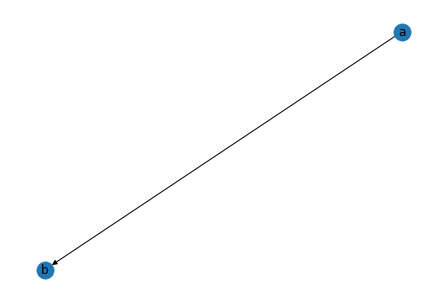

In [6]:
nx.draw(g, with_labels=True)

In [7]:
print(''.join([v for v in nx.readwrite.gml.generate_gml(g)]))

graph [  directed 1  node [    id 0    label "a"  ]  node [    id 1    label "b"  ]  edge [    source 0    target 1  ]]


## Creating data using a linear model

Contains:
* data generation with a linear model using `create_linear_dataset`
* generating a `nx` graph to model the generated data using `create_nxgraph`

Graph variable naming scheme:
* `v`: treatment
* `y`: outcome
* `w`: common cause
* `z`: instrument
* `x`: effect modifier

In [8]:
#export
def stochastically_convert_to_binary(x:float):
    p = 1/(1+np.exp(-x))  # sigmoid
    return np.random.choice([0, 1], size=1, p=[1-p, p])

In [9]:
stochastically_convert_to_binary(1)

array([1])

In [10]:
#export
def create_nxgraph(treatments:typing.List[str], outcome:str, common_causes:typing.List[str],
                   instruments:typing.List[str], effect_modifiers:typing.List[str]=[],
                   unobs_conf:str="Unobserved Confounder"):
    'Created a specific directed acyclic graph used for the `create_linear_dataset` function.'
    g = nx.DiGraph()
    
    g.add_edge(unobs_conf, outcome)
    g.add_edges_from([(treatment, outcome) for treatment in treatments])
    g.add_edges_from([(unobs_conf, treatment) for treatment in treatments])
    g.add_edges_from([(common_cause, treatment) 
                      for common_cause, treatment in itertools.product(common_causes, treatments)])
    g.add_edges_from([(instrument, treatment) 
                      for instrument, treatment in itertools.product(instruments, treatments)])
    g.add_edges_from([(common_cause, outcome) for common_cause in common_causes])
    g.add_edges_from([(effect_modifier, outcome) for effect_modifier in effect_modifiers])
    return g

graph [  directed 1  node [    id 0    label "Unobserved Confounder"  ]  node [    id 1    label "y"  ]  node [    id 2    label "v0"  ]  node [    id 3    label "W0"  ]  node [    id 4    label "W1"  ]  node [    id 5    label "W2"  ]  node [    id 6    label "W3"  ]  node [    id 7    label "W4"  ]  node [    id 8    label "Z0"  ]  node [    id 9    label "Z1"  ]  node [    id 10    label "X0"  ]  edge [    source 0    target 1  ]  edge [    source 0    target 2  ]  edge [    source 2    target 1  ]  edge [    source 3    target 2  ]  edge [    source 3    target 1  ]  edge [    source 4    target 2  ]  edge [    source 4    target 1  ]  edge [    source 5    target 2  ]  edge [    source 5    target 1  ]  edge [    source 6    target 2  ]  edge [    source 6    target 1  ]  edge [    source 7    target 2  ]  edge [    source 7    target 1  ]  edge [    source 8    target 2  ]  edge [    source 9    target 2  ]  edge [    source 10    target 1  ]]


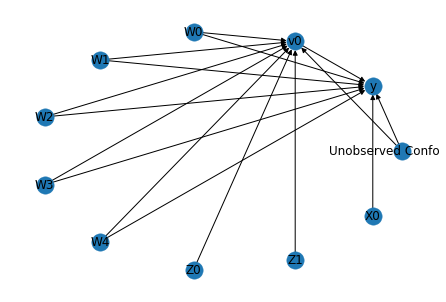

In [11]:
num_treatments = 1
num_common_causes = 5
num_instruments = 2
num_effect_modifiers = 1

effect_modifiers = [f'X{i}' for i in range(num_effect_modifiers)]
instruments = [f'Z{i}' for i in range(num_instruments)]
common_causes = [f'W{i}' for i in range(num_common_causes)]
treatments = [f'v{i}' for i in range(num_treatments)]
outcome = ['y']

g = create_nxgraph(treatments, outcome[0], common_causes, instruments, effect_modifiers)
print(''.join([v for v in nx.readwrite.gml.generate_gml(g)]))

nx.draw_circular(g, with_labels=True)
plt.show()

The linear model:
$$t = \varepsilon + W \cdot c_1 + Z \cdot c_z$$

$$y = t \cdot \beta + W \cdot c_2 + X \cdot c_e \cdot t$$

In [12]:
#export
def create_linear_dataset(beta:typing.Union[int,float,list,np.ndarray], 
                   num_treatments:int, num_common_causes:int, num_samples:int,
                   num_instruments:int, num_effect_modifiers:int,
                   treatment_is_binary:bool,
                   outcome_is_binary:bool):
    '''Generates data using a linear model
    
    treament: $t = \varepsilon + W \cdot c_1 + Z \cdot c_z$
    output: $y = t \cdot \beta + W \cdot c_2 + X \cdot c_e \cdot t$
    
    Names assigned in ret_dict['df']
    * `V`: treatment
    * `Y`: outcome
    * `W`: common cause
    * `Z`: instrument
    * `x`: effect modifier
    '''
    W, X, Z, c1, c2, ce, cz = [None]*7
    
    beta = float(beta)
    
    if not isinstance(beta, (list, np.ndarray)):
        beta = np.repeat(beta, num_treatments)
    
    if num_common_causes > 0:
        range_c1 = max(beta) * .5
        range_c2 = max(beta) * .5
        means = np.random.uniform(-1, 1, num_common_causes)
        cov_mat = np.diag(np.ones(num_common_causes))
        W = np.random.multivariate_normal(means, cov_mat, size=num_samples)
        c1 = np.random.uniform(0, range_c1, size=(num_common_causes, num_treatments))
        c2 = np.random.uniform(0, range_c2, size=num_common_causes)
        
    if num_instruments > 0:
        range_cz = beta
        p = np.random.uniform(0, 1, num_instruments)
        Z = np.zeros((num_samples, num_instruments))
        for i in range(num_instruments):
            if (i % 2) == 0:
                Z[:, i] = np.random.binomial(n=1, p=p[i], size=num_samples)  # ???
            else:
                Z[:, i] = np.random.uniform(0, 1, size=num_samples)  # ???
        # TODO Ensure that we do not generate weak instruments
        cz = np.random.uniform(low=range_cz - range_cz * .05,
                               high=range_cz + range_cz * .05, 
                               size=(num_instruments, num_treatments))
        
    if num_effect_modifiers >0:
        range_ce = beta * .5
        means = np.random.uniform(-1, 1, num_effect_modifiers)
        cov_mat = np.diag(np.ones(num_effect_modifiers))
        X = np.random.multivariate_normal(means, cov_mat, num_samples)
        ce = np.random.uniform(0, range_ce, num_effect_modifiers)
    # TODO - test all our methods with random noise added to covariates (instead of the stochastic treatment assignment)
    
    t = np.random.normal(0, 1, size=(num_samples, num_treatments))
    
    if num_common_causes > 0:
        t += W @ c1
    
    if num_instruments > 0:
        t += Z @ cz
    
    # Converting treatment to binary if required
    if treatment_is_binary:
        t = np.vectorize(stochastically_convert_to_binary)(t)
    
    
    def _compute_y(t, W, X, beta, c2, ce):
        y =  t @ beta
        if num_common_causes > 0:
            y += W @ c2
        if num_effect_modifiers > 0:
            y += (X @ ce) * np.prod(t, axis=1)
        return y
    
    y = _compute_y(t, W, X, beta, c2, ce)
    
    if outcome_is_binary:
        y = np.vectorize(stochastically_convert_to_binary)(t)
    
    
    data = np.column_stack((t, y))
    if num_common_causes > 0:
        data = np.column_stack((W, data))
    if num_instruments > 0:
        data = np.column_stack((Z, data))
    if num_effect_modifiers > 0:
        data = np.column_stack((X, data))
    
    effect_modifiers = [f'X{i}' for i in range(num_effect_modifiers)]
    instruments = [f'Z{i}' for i in range(num_instruments)]
    common_causes = [f'W{i}' for i in range(num_common_causes)]
    treatments = [f'v{i}' for i in range(num_treatments)]
    outcome = ['y']
    data = pd.DataFrame(
        data=data,
        columns=effect_modifiers + instruments + common_causes \
                + treatments + outcome
    )
        
    # Specifying the correct dtypes
    if treatment_is_binary:
        data = data.astype({tname:'bool' for tname in treatments}, copy=False)
    if outcome_is_binary:
        data = data.astype({outcome: 'bool'}, copy=False)
    
    ate = np.mean(_compute_y(np.ones((num_samples, num_treatments)), W, X, beta, c2, ce) 
                  - _compute_y(np.zeros((num_samples, num_treatments)), W, X, beta, c2, ce))
    
    # Now writing the gml graph
    g = create_nxgraph(treatments, outcome[0], common_causes, instruments, effect_modifiers)
    gml_graph = ''.join([v for v in nx.readwrite.gml.generate_gml(g)])
    ret_dict = {
        "df": data,
        "treatment_name": treatments,
        "outcome_name": outcome[0],
        "common_causes_names": common_causes,
        "instrument_names": instruments,
        "effect_modifier_names": effect_modifiers,
        "gml_graph": gml_graph,
        "g": g,
        "average_treatment_effect": ate
    }
    return ret_dict

In [13]:
beta = 10
num_treatments = 1
num_common_causes = 5
num_samples = 4000
num_instruments = 2
num_effect_modifiers = 1
treatment_is_binary = False
outcome_is_binary = False

lin_data = create_linear_dataset(beta, num_treatments=num_treatments, num_common_causes=num_common_causes,
                                 num_samples=num_samples, num_instruments=num_instruments,
                                 num_effect_modifiers=num_effect_modifiers,
                                 treatment_is_binary=treatment_is_binary,
                                 outcome_is_binary=outcome_is_binary)

In [14]:
lin_data

{'df':             X0   Z0        Z1        W0        W1        W2        W3  \
 0     0.578819  0.0  0.280296  0.024574 -1.324071  0.942699  1.375590   
 1     1.283018  0.0  0.076524 -1.580302 -0.444682  0.127392 -0.730738   
 2    -1.250157  1.0  0.081374 -0.246647 -0.450948 -0.423340 -0.170045   
 3    -0.229274  0.0  0.199054 -1.788206 -1.016941 -0.944024  0.797348   
 4    -1.013381  1.0  0.749263 -1.708354 -0.824702 -0.616313  0.520717   
 ...        ...  ...       ...       ...       ...       ...       ...   
 3995 -0.439361  0.0  0.736427  0.577764 -0.726857  0.798468 -0.046395   
 3996 -1.747086  0.0  0.458491 -1.967143 -1.188980 -1.222641 -0.282264   
 3997 -2.292280  0.0  0.744078  0.873812 -1.084863 -0.124528 -0.132609   
 3998 -1.344232  0.0  0.804614 -1.357455  0.648468  0.709424 -2.869342   
 3999  0.098588  1.0  0.805784  0.143415 -1.055753 -2.786900 -2.201823   
 
             W4         v0           y  
 0     0.364255  10.345023  117.317028  
 1     0.811735  -1.71

In [15]:
df = lin_data["df"]
df.head()

,X0,Z0,Z1,W0,W1,W2,W3,W4,v0,y
0,0.578819,0.0,0.280296,0.024574,-1.324071,0.942699,1.375590,0.364255,10.345023,117.317028
1,1.283018,0.0,0.076524,-1.580302,-0.444682,0.127392,-0.730738,0.811735,-1.712657,-27.389258
2,-1.250157,1.0,0.081374,-0.246647,-0.450948,-0.423340,-0.170045,0.029042,8.296854,57.681320
3,-0.229274,0.0,0.199054,-1.788206,-1.016941,-0.944024,0.797348,-0.957332,-6.012101,-73.155142
4,-1.013381,1.0,0.749263,-1.708354,-0.824702,-0.616313,0.520717,-0.359838,12.513062,87.997089


## Doing some basic analysis

In [16]:
len(df)

In [17]:
c = df.corr(method='spearman'); c

,X0,Z0,Z1,W0,W1,W2,W3,W4,v0,y
X0,1.000000,-0.022681,-0.006247,0.010658,-0.020296,-0.013433,-0.029697,0.019778,-0.014280,-0.015976
Z0,-0.022681,1.000000,-0.010051,-0.018347,-0.019562,0.013709,0.023991,-0.017934,0.510915,0.466814
Z1,-0.006247,-0.010051,1.000000,0.004919,0.013111,0.027248,0.004799,-0.014842,0.388713,0.355818
W0,0.010658,-0.018347,0.004919,1.000000,0.003432,-0.007353,0.018447,0.013433,0.294682,0.321348
W1,-0.020296,-0.019562,0.013111,0.003432,1.000000,0.003548,0.008391,-0.013856,0.007956,0.069226
W2,-0.013433,0.013709,0.027248,-0.007353,0.003548,1.000000,-0.005188,0.000300,0.384315,0.385542
W3,-0.029697,0.023991,0.004799,0.018447,0.008391,-0.005188,1.000000,0.012614,0.364629,0.371712
W4,0.019778,-0.017934,-0.014842,0.013433,-0.013856,0.000300,0.012614,1.000000,0.377000,0.407094
v0,-0.014280,0.510915,0.388713,0.294682,0.007956,0.384315,0.364629,0.377000,1.000000,0.988044
y,-0.015976,0.466814,0.355818,0.321348,0.069226,0.385542,0.371712,0.407094,0.988044,1.000000


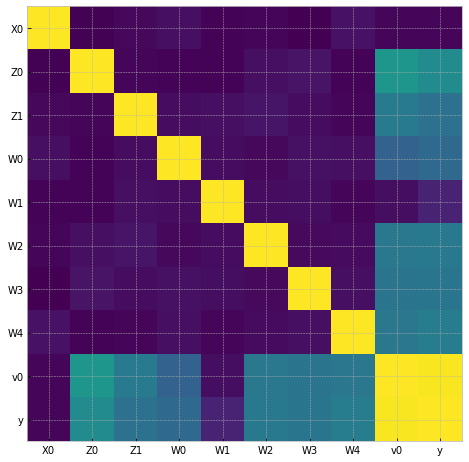

In [18]:
fig, ax = plt.subplots(figsize=(8,8))
ax.imshow(c)
ax.set(xticks=range(len(df.columns)), xticklabels=df.columns,
       yticks=range(len(df.columns)), yticklabels=df.columns)
plt.show()

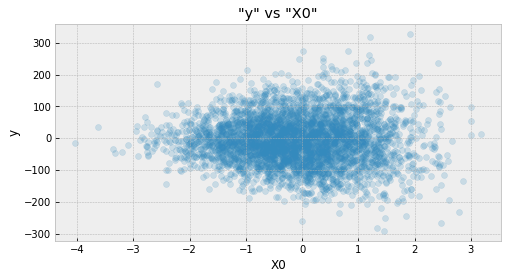

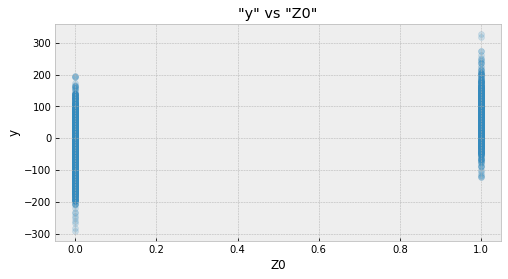

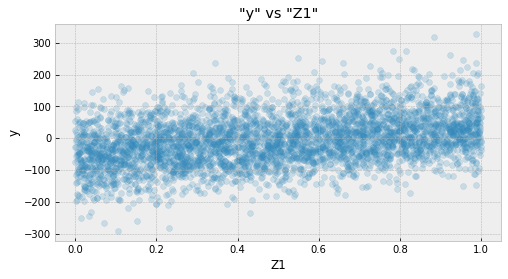

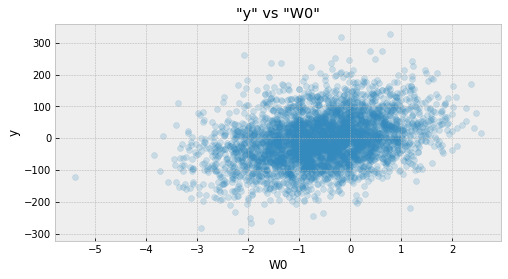

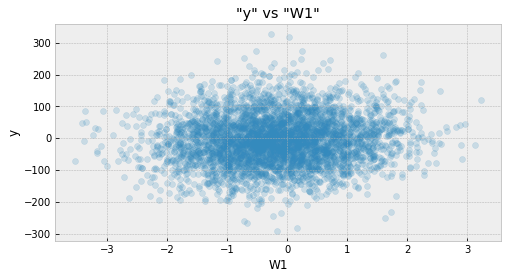

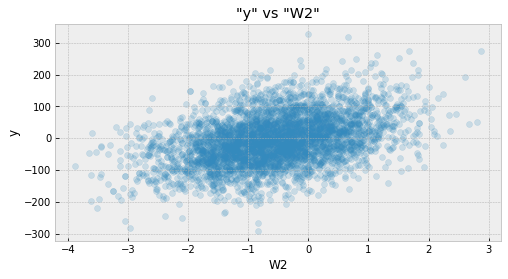

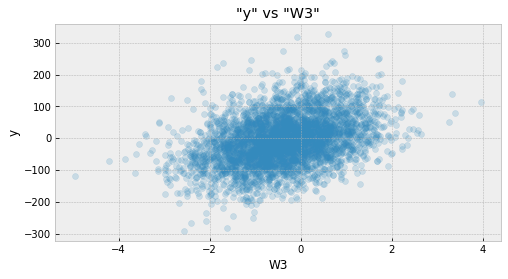

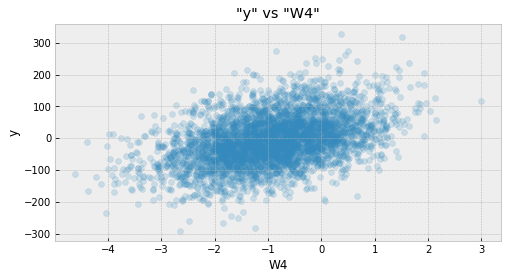

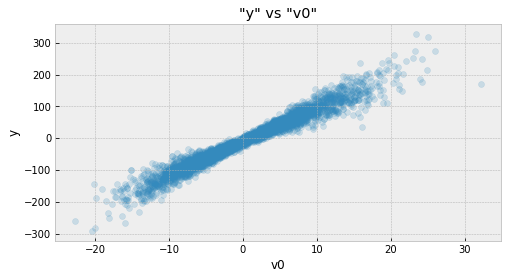

In [19]:
target = 'y'
for col in df.columns:
    if col == target: continue
    fig, ax = plt.subplots(figsize=(8,4))
    ax.scatter(col, target, data=df, alpha=.2)
    ax.set(xlabel=col, ylabel=target, title=f'"{target}" vs "{col}"')
    plt.show()

## Computing feature importance and partial dependency

In [20]:
x_cols = [col for col in df.columns if col != target]
X, y = df.loc[:, x_cols].values, df.loc[:, [target]].values.ravel()
m = ensemble.RandomForestRegressor(max_features='sqrt', n_estimators=100, oob_score=True)
m.fit(X,y)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='sqrt', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=100,
                      n_jobs=None, oob_score=True, random_state=None, verbose=0,
                      warm_start=False)

In [21]:
m.oob_score_

In [22]:
#export
def get_feature_importance(m, X:np.ndarray, y:np.ndarray, x_cols:list):
    n_obs, n_row = X.shape
    scores = {}
    for i in range(n_row):
        _X = X.copy()
        np.random.shuffle(_X[:,i])
        _y = m.predict(_X)
        scores[i] = metrics.mean_squared_error(y, _y)
        
    scores = pd.DataFrame([{'variable': x_cols[i], 'feature_importance': scores[i]} for i in scores]) 
    scores.sort_values('feature_importance', ascending=False, inplace=True)
    return scores

In [23]:
%%time
fi = get_feature_importance(m, X, y, x_cols)

CPU times: user 547 ms, sys: 0 ns, total: 547 ms
Wall time: 555 ms


In [24]:
fi

,variable,feature_importance
8,v0,7349.625845
0,X0,220.439273
1,Z0,183.161329
7,W4,127.495312
5,W2,90.508932
6,W3,75.841222
2,Z1,72.840283
3,W0,66.386968
4,W1,35.378510


In [25]:
_y = m.predict(X)

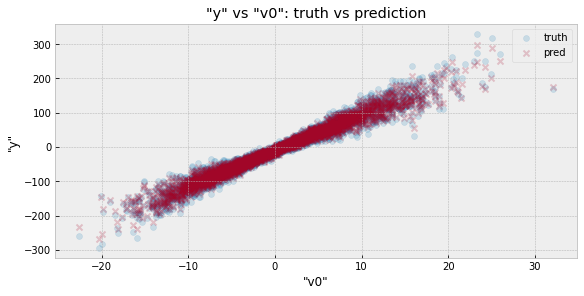

In [26]:
idp_var = 'v0'
ix = x_cols.index(idp_var)

fig, ax = plt.subplots(figsize=(8,4), constrained_layout=True)
jitter = np.random.normal(loc=0, scale=.01, size=len(y))
ax.scatter(X[:,ix]+jitter, y, label='truth', marker='o', alpha=.2)
ax.scatter(X[:,ix]+jitter, _y, label='pred', marker='x', alpha=.2)
ax.set(xlabel=f'"{idp_var}"', ylabel=f'"{target}"', 
       title=f'"{target}" vs "{idp_var}": truth vs prediction')
ax.legend(loc='best')
plt.show()

In [38]:
#export
def partial_dependence(m, X:np.ndarray, y:np.ndarray, x_cols:list,
                       idp_col:str, max_num_obs:int=100, max_num_ys:int=10):
    n_obs, n_row = X.shape
    ys = {}
    ix = x_cols.index(idp_col)
    
    idp_vals = np.unique(X[:,ix])
    n_u = len(idp_vals)
    step = n_u//max_num_ys if max_num_ys >= n_u else 1
    idp_vals = idp_vals[::step]
    
    if max_obs:
        if max_obs >= n_obs:
            ixs = np.arange(n_obs)
        else:
            ixs = np.random.choice(np.arange(n_obs), size=max_num_obs,
                                   replace=False)
    for i, val in enumerate(idp_vals):
        _X = X[ixs,:].copy()
        _X[:,ix] = val
        _y = m.predict(_X)
        ys[i] = _y.copy()
        
    part_deps = pd.DataFrame({val: ys[i] for i,val in enumerate(idp_vals)})
    return part_deps

In [49]:
idp_col = 'v0'
max_num_obs = 100
max_num_ys = 100
part_dep_res = partial_dependence(m, X, y, x_cols, idp_col, 
                                  max_num_obs=max_num_obs, 
                                  max_num_ys=max_num_ys)

In [50]:
part_dep_res.head()

,-22.668735,-15.273955,-13.322940,-12.354215,-11.636034,-10.856567,-10.297040,-9.768048,-9.359426,-8.977915,...,9.780089,10.256475,10.922252,11.513036,12.205872,12.942585,13.679436,14.790349,16.008724,18.350436
0,-175.263262,-161.006681,-156.843960,-150.082942,-143.805136,-139.187224,-131.343978,-125.580945,-119.456960,-116.220853,...,47.350946,49.328625,51.153022,54.833989,55.168166,59.653928,62.153723,63.511569,65.752189,68.094830
1,-102.735343,-99.351246,-98.189206,-95.565448,-93.925617,-93.122148,-86.694303,-78.981959,-77.640165,-75.646536,...,97.692996,99.941003,102.294485,106.492559,109.226566,111.046935,117.498469,120.511748,131.005324,137.705433
2,-122.652512,-121.096879,-119.544065,-117.146554,-114.154586,-112.049113,-108.997333,-103.285500,-101.136943,-98.825992,...,86.244863,90.819999,93.277513,96.699426,99.260987,103.789127,107.683802,109.596986,113.873197,117.477070
3,-121.593672,-114.541635,-111.398617,-107.391945,-105.909459,-102.994117,-96.908267,-90.197467,-85.266926,-82.250167,...,94.412653,97.354330,102.179810,104.762089,106.499080,108.036228,113.629402,118.766260,125.797171,129.534316
4,-151.230063,-137.249700,-133.755543,-131.387330,-123.636407,-118.248712,-113.583162,-110.610023,-106.815424,-102.672061,...,52.572286,52.865663,56.959778,58.797316,59.709186,64.273062,64.847325,66.241387,70.230915,72.785667


In [52]:
#export
def plot_partial_dependency(part_dep_res:pd.DataFrame, idp_col:str,
                            target:str):
    fig, ax = plt.subplots(figsize=(8,4), constrained_layout=True)
    x = part_dep_res.columns.values
    for i, row in part_dep_res.iterrows():
        ax.plot(x, row.values, alpha=.1, lw=1, color='black')
    ax.set(xlabel=f'"{idp_col}"', ylabel=f'"{target}"', title=f'Partial dependency plot "{target}" vs "{idp_col}"')
    plt.show()

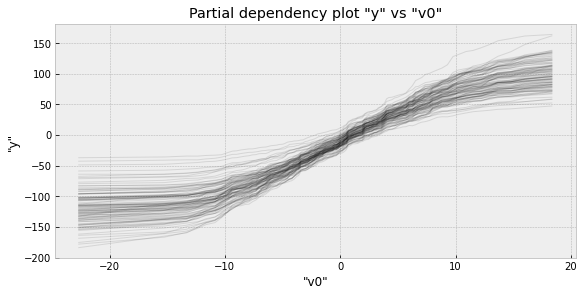

In [53]:
plot_partial_dependency(part_dep_res, idp_col, target)

## Computing and refusing causal estimates

In [111]:
# With graph
model = CausalModel(data=df.copy(), treatment=lin_data['treatment_name'],
                    outcome=lin_data['outcome_name'], graph=lin_data['gml_graph'])

INFO:dowhy.causal_model:Model to find the causal effect of treatment ['v0'] on outcome ['y']


INFO:dowhy.causal_graph:Using Matplotlib for plotting


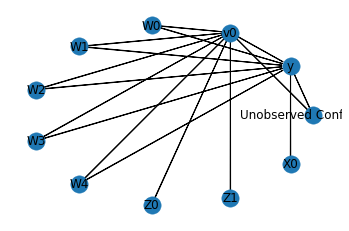

In [112]:
model.view_model()

Identification

'iv' = instrumental variable

In [113]:
identified_estimand = model.identify_effect()
print(identified_estimand)

INFO:dowhy.causal_identifier:Common causes of treatment and outcome:['W2', 'W4', 'W0', 'W3', 'W1', 'Unobserved Confounder']


WARN: Do you want to continue by ignoring any unobserved confounders? (use proceed_when_unidentifiable=True to disable this prompt) [y/n] y


INFO:dowhy.causal_identifier:Instrumental variables for treatment and outcome:['Z0', 'Z1']


Estimand type: nonparametric-ate
### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                                 
─────(Expectation(y|W2,W4,W0,W3,W1))
d[v₀]                               
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W2,W4,W0,W3,W1,U) = P(y|v0,W2,W4,W0,W3,W1)
### Estimand : 2
Estimand name: iv
Estimand expression:
Expectation(Derivative(y, [Z0, Z1])*Derivative([v0], [Z0, Z1])**(-1))
Estimand assumption 1, As-if-random: If U→→y then ¬(U →→{Z0,Z1})
Estimand assumption 2, Exclusion: If we remove {Z0,Z1}→{v0}, then ¬({Z0,Z1}→y)



Practical meaning of `control_value` and `treatment_value` for `CausalModel.estimate_effect`?

In linear regression `control_value` and `treatment_value` are used to apply the do operator. Practically the respective values replace the treatment values from the original data and making predictions (like partial dependency plots) and then computing the difference to obtain the effect estimate.

Difference between `'regression_discontinuity'` and `'linear_regression'`?

Difference between `'instrumental_variable'` and `'backdoor'`?

In [132]:
# method_name = 'backdoor.propensity_score_stratification'
# method_name = 'backdoor.propensity_score_matching'
# method_name = 'backdoor.propensity_score_weighting'
method_name = 'backdoor.linear_regression'
# method_name = 'iv.instrumental_variable'
# method_name = 'iv.regression_discontinuity'
control_value = 0
treatment_value = 1
causal_estimate = model.estimate_effect(identified_estimand,
                                        method_name=method_name,
                                        control_value=control_value,
                                        treatment_value=treatment_value
                                        )

INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: y~v0+W2+W4+W0+W3+W1+v0*X0


In [133]:
print(causal_estimate)

*** Causal Estimate ***

## Target estimand
Estimand type: nonparametric-ate
### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                                 
─────(Expectation(y|W2,W4,W0,W3,W1))
d[v₀]                               
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W2,W4,W0,W3,W1,U) = P(y|v0,W2,W4,W0,W3,W1)
### Estimand : 2
Estimand name: iv
Estimand expression:
Expectation(Derivative(y, [Z0, Z1])*Derivative([v0], [Z0, Z1])**(-1))
Estimand assumption 1, As-if-random: If U→→y then ¬(U →→{Z0,Z1})
Estimand assumption 2, Exclusion: If we remove {Z0,Z1}→{v0}, then ¬({Z0,Z1}→y)

## Realized estimand
b: y~v0+W2+W4+W0+W3+W1+v0*X0
## Estimate
Value: 9.999999999999984



Refute estimate tries to see which changes to the data / graph decrease or increase the estimate. The placebo approach is to replace the treatment, with a placebo. Which sounds alot like the feature importance approach where features are permuted one by one to see the worsening of the model predictions.

`method_name`:
* "random_common_cause": Adding a randomly-generated confounder
* "add_unobserved_common_cause": Adding a confounder that is associated with both treatment and outcome
* "placebo_treatment_refuter": Replacing the treatment with a placebo (random) variable)
* "data_subset_refuter": Removing a random subset of the data

In [118]:
res_random = model.refute_estimate(identified_estimand, 
                                   causal_estimate, 
                                   method_name="random_common_cause")

INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: y~v0+W2+W4+W0+W3+W1+w_random+v0*X0


In [119]:
print(res_random)

Refute: Add a Random Common Cause
Estimated effect:(9.999999999999984,)
New effect:(9.999999999999988,)



In [120]:
res_placebo = model.refute_estimate(identified_estimand, causal_estimate,
        method_name="placebo_treatment_refuter", placebo_type="permute")

INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: y~placebo+W2+W4+W0+W3+W1+placebo*X0


In [121]:
print(res_placebo)

Refute: Use a Placebo Treatment
Estimated effect:(9.999999999999984,)
New effect:(0.9449186044422113,)



Here the estimated effect significantly breaks down when using a placebo. Does this indicate that the treatment has a significant influence over the outcome?

In [122]:
res_subset = model.refute_estimate(identified_estimand, causal_estimate,
        method_name="data_subset_refuter", subset_fraction=0.9)

INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: y~v0+W2+W4+W0+W3+W1+v0*X0


In [123]:
print(res_subset)

Refute: Use a subset of data
Estimated effect:(9.999999999999984,)
New effect:(10.000000000000007,)

